## Visualiser les échantillons

In [582]:
import sys
sys.path.append('/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/python_scripts')
import os
from sklearn.model_selection import train_test_split

# personal librairies
import classification as cla

# 1 --- define parameters 
# inputs
my_folder = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/aumelas/'
sample_filename = os.path.join(my_folder, 'sample_strata.tif')
image_filename = os.path.join(my_folder, 'aumelas_orthoirc.tif')

# 2 --- extract samples 
X, Y, t = cla.get_samples_from_roi(image_filename, sample_filename)

### Histogramme 1D

La première chose que vous pouvez faire pour explorer le comportement spectrale est d'afficher l'histogramme sur une ou plusieurs bandes. 

#### Histogramme des échantillons par bandes

##### Affichage pour une bande

Nous allons pour cela utiliser la fonction `hist` de ==matplotlib== : 

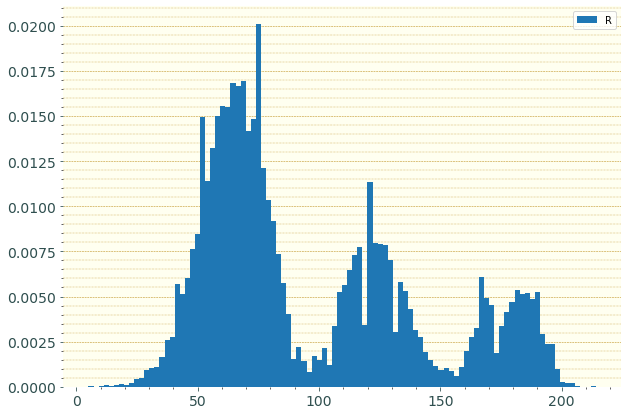

In [298]:
import matplotlib.pyplot as plt
import plots

# create plot
fig, ax = plt.subplots(figsize=(10, 7))

# here we decide to plot the Red band
labels = ['R']
band = X[:, 1]
vals, bins, patch = ax.hist(band,  # band to display
                            bins=100, # number of binds
                            label=labels, # for the legend
                            density=True, # if count are normalized
                            zorder=2) 

# display the legend
ax.legend()

# custom the background
ax = plots.custom_bg(ax, x_grid=False)

Dépendamment de la qualité radiométrique de votre image et du nombre *bins* d'intervalles, vous pouvez obtenir un histogramme plus ou moins bruité, plus ou moins lisse. Une solution pour faciliter la lecture d'un histogramme est de tracer une fonction qui interpole votre histogramme. 

Pour ce faire, nous allons utiliser la fonction `KernelDensity` de ==Scikit Learn==.

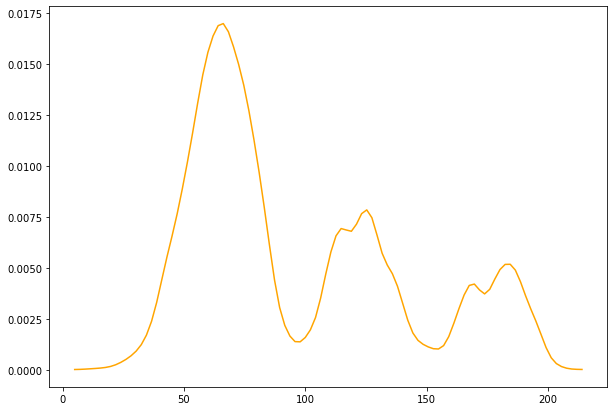

In [303]:
import numpy as np
from sklearn.neighbors import KernelDensity

# get band to display 
band = X[:, 1]

# get 100 values between the min and the max of band
X_plot = np.linspace(band.min(), band.max(), 100)[:, np.newaxis]

# define kernel density
kde = KernelDensity(bandwidth=3)
# learn kernel
kde.fit(band.reshape(-1, 1))
# predict on our X
log_dens = kde.score_samples(X_plot)
density = np.exp(log_dens)

# plot it
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(X_plot[:,0], density , color='orange', 
        zorder=3, linewidth=1.5,
        linestyle='-')

Affichons maintenant les deux représentations superposées. 

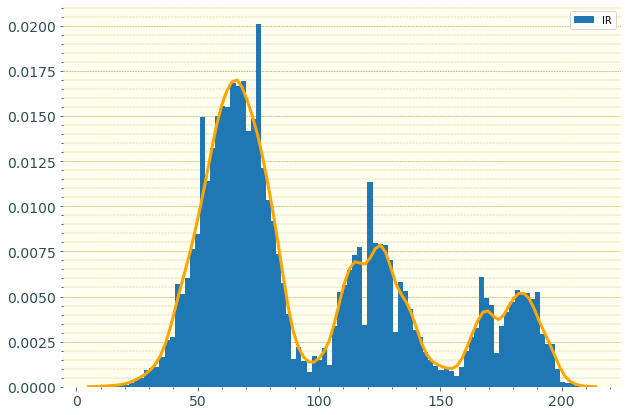

In [310]:
fig, ax = plt.subplots(figsize=(10, 7))
labels = ['IR', 'R', 'G']
band = X[:, 1]
vals, bins, patch = ax.hist(band, bins=100, label=labels, density=True,
                           zorder=2)
ax.legend()
ax = plots.custom_bg(ax, x_grid=False)

# get 100 values between the min and the max of band
X_plot = np.linspace(band.min(), band.max(), 100)[:, np.newaxis]

# define kernel density
kde = KernelDensity(bandwidth=3)
# learn kernel
kde.fit(band.reshape(-1, 1))
# predict on our X
log_dens = kde.score_samples(X_plot)
density = np.exp(log_dens)

# plot it
ax.plot(X_plot[:,0], density , color='orange', 
        zorder=3, linewidth=3,
        linestyle='-')

Exercice : 

Reproduisez cette figure et faites varier les paramètre `bins` et `bandwidth` et observez leur influence.

##### Affichage pour plusieurs bandes

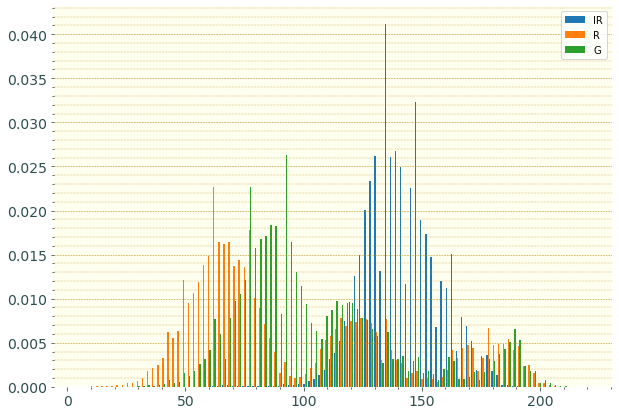

In [546]:
import matplotlib.pyplot as plt
import plots
fig, ax = plt.subplots(figsize=(10, 7))
labels = ['IR', 'R', 'G']
vals, bins, patch = ax.hist(X, bins=100, label=labels, density=True)
ax.legend()
ax = plots.custom_bg(ax, x_grid=False)

La lecture des histogrammes n'est pas facile ici. Essayons de calculer et d'afficher leur interpolation. 

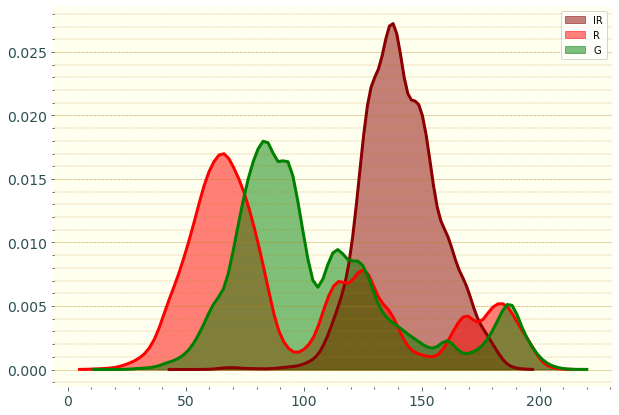

In [330]:
import numpy as np
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
import plots

fig, ax = plt.subplots(figsize=(10, 7))

color = ['darkred', 'red', 'green']
labels = ['IR', 'R', 'G']
for idx_band, col, label in zip(range(3), color, labels):
    band = X[:, idx_band]    
    # get 100 values between the min and the max of band
    X_plot = np.linspace(band.min(), band.max(), 100)[:, np.newaxis]

    # define kernel density
    kde = KernelDensity(bandwidth=3)
    # learn kernel
    kde.fit(band.reshape(-1, 1))
    # predict on our X
    log_dens = kde.score_samples(X_plot)
    density = np.exp(log_dens)

    # plot it
    ax.plot(X_plot[:,0], density , color=col, 
            zorder=3, linewidth=3,
            linestyle='-')
    # fill space between lines and the x axis (0)
    ax.fill_between(X_plot[:,0], 0, density, alpha=0.5, color=col, label=label)
    
ax.legend()
ax = plots.custom_bg(ax, x_grid=False)

C'est une donnée interpolée, mais elle plus lisible : les différents modes sont ici facilement visibles.

Astuces / Rappel

La fonction `zip` permet de d'iterer sur plusieurs iterateurs en même temps : 

In [315]:
iterateur1 = [1, 2, 3]
iterateur2 = ['premier', 'deuxième', 'troisième']
for it1, it2 in zip(iterateur1, iterateur2):
    print(it1)
    print(it2)
    print('--------')

1
premier
New iteration
2
deuxième
New iteration
3
troisième
New iteration


Et si vous avez besoin d'un compteur, vous pouvez toujours utiliser la fonction `enumerate`:

In [316]:
iterateur1 = [1, 2, 3]
iterateur2 = ['premier', 'deuxième', 'troisième']
for compteur, (it1, it2) in enumerate(zip(iterateur1, iterateur2)):
    print(it1)
    print(it2)
    print(compteur)
    print('-------')

1
premier
0
-------
2
deuxième
1
-------
3
troisième
2
-------


Astuce :

Voici un panel de couleurs que vous pouvez renseigner dans de nombreuses fonctions de ==Matplotlib==

![](../../img/td_visu/matplotlib_colors.png)

Exercice :

Reproduire la figure ci-dessus et personnalisez la avec les couleurs de votre choix.

#### Histogramme de chaque classe pour une bande

Afin d'avoir l'affichage de plusieurs bandes de manière séparée, nous allons utiliser plusieurs subplots :

##### Prise en main des subplots

Jusqu'à présent la nous utilisions la fonction `plt.suplots()` en ne renseignant comme argument que la taille de la figure. La fonction retournait alors une instance `matplotlib.figure.Figure` (que nous utilisons très peu) et une instance `matplotlib.axes._subplots.AxesSubplot` qui correspond à la zone d'affichage. C'est la classe que nous manipulons le plus.

<class 'matplotlib.figure.Figure'>
<class 'matplotlib.axes._subplots.AxesSubplot'>


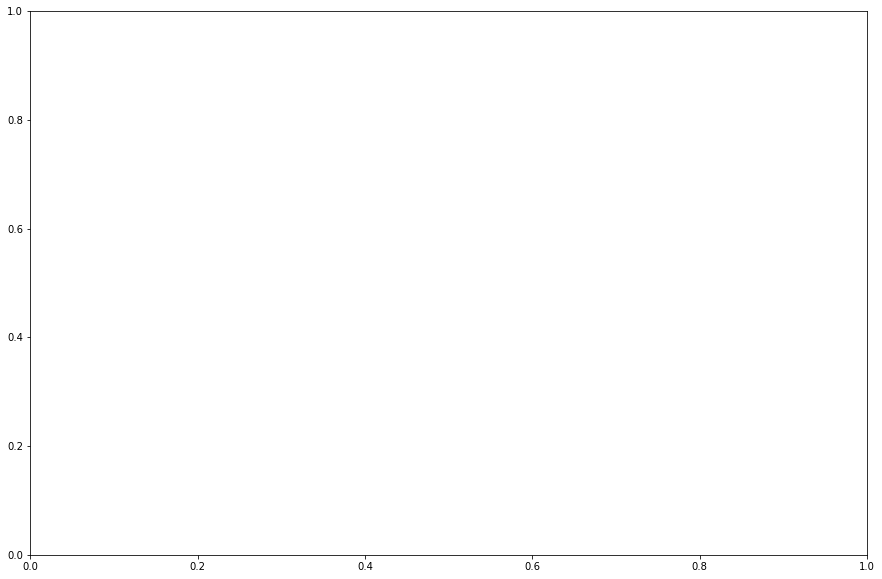

In [337]:
fig, ax = plt.subplots(figsize=(15, 10))
print(type(fig))
print(type(ax))

Il est possible de renseigner le nombre de lignes (`nrows`) et de colonnes (`ncols`) souhaitées. Ces arguments ont une valeur de 1 par défaut. Si `nrows > 1` ou `ncols > 1`, la fonction ne retourne plus une instance de `matplotlib.axes._subplots.AxesSubplot` mais une matrice ==Numpy== de `matplotlib.axes._subplots.AxesSubplot`. Les tableaux Numpy sont partout !

<class 'numpy.ndarray'>
(2, 2)
<class 'matplotlib.axes._subplots.AxesSubplot'>


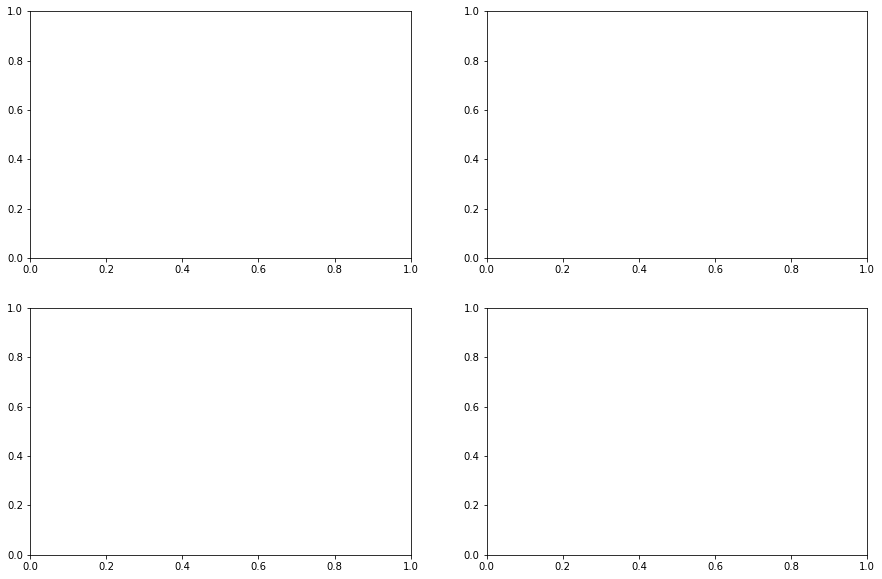

In [340]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
print(type(axes))
print(axes.shape)
print(type(axes[0,0]))

Il est ainsi possible d'itérer sur les `axes` d'un suplot. Plus précisément, nous allonrs itérer sur le tableau des intances "aplaties" (on transforme le tableau 2D en tableau 1D) grace à la méthode `flatten()` des tableaux ==Numpy==: 

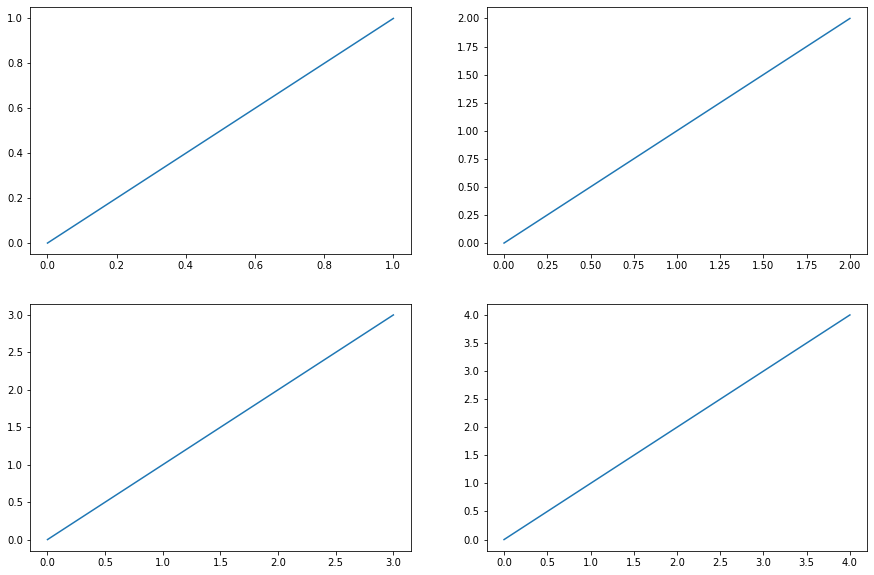

In [342]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
for i, ax in enumerate(axes.flatten()):
    data = range(0, i + 2)
    ax.plot(data, data)

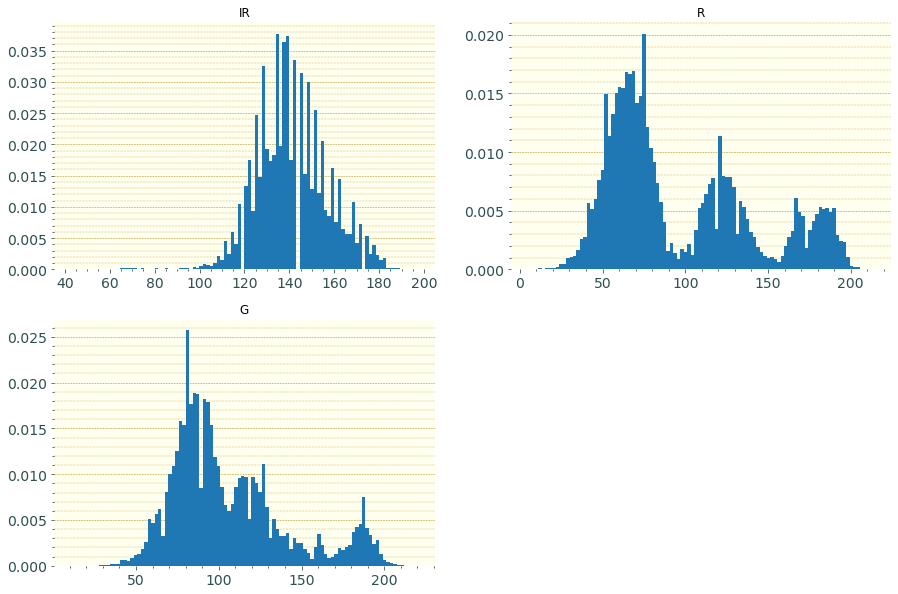

In [343]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
list_title = ['IR', 'R', 'G']
my_iterator = zip(axes.flatten(), list_title)
for i, (ax, title) in enumerate(my_iterator):
    band = X[:, i]
    vals, bins, patch = ax.hist(band, bins=100,  density=True, zorder=2)
    ax.set_title(title)
    ax = plots.custom_bg(ax, x_grid=False)
    
_ = axes[1][1].axis('off')

Rajoutons les histogrammes interpollés : 

(0.0, 1.0, 0.0, 1.0)

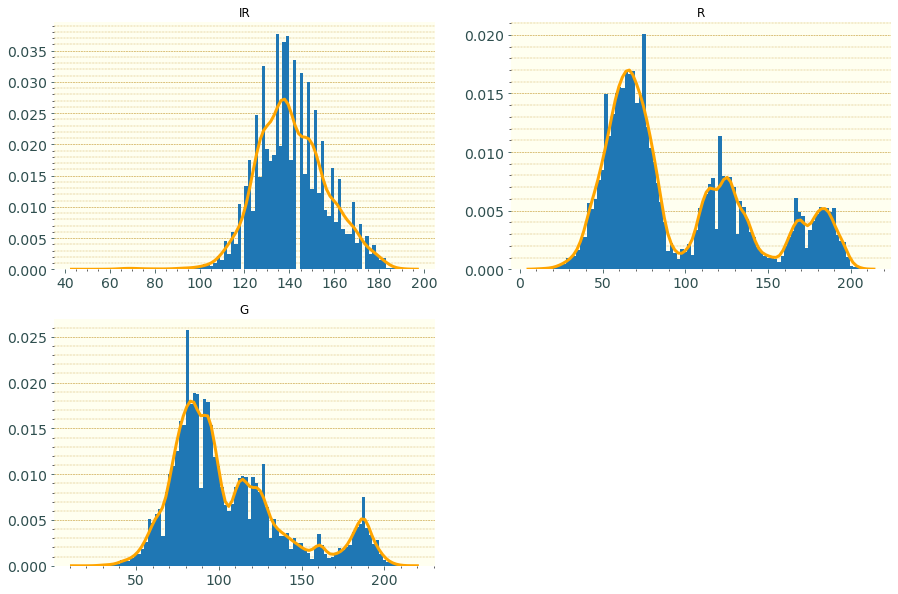

In [328]:
import numpy as np
from sklearn.neighbors import KernelDensity

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
list_title = ['IR', 'R', 'G']
my_iterator = zip(axes.flatten(), list_title)
for i, (ax, title) in enumerate(my_iterator):    
    band = X[:, i]
    vals, bins, patch = ax.hist(band, bins=100, label=labels, density=True,
                           zorder=2)
    
    # get 100 values between the min and the max of band
    X_plot = np.linspace(band.min(), band.max(), 100)[:, np.newaxis]

    # define kernel density
    kde = KernelDensity(bandwidth=3)
    # learn kernel
    kde.fit(band.reshape(-1, 1))
    # predict on our X
    log_dens = kde.score_samples(X_plot)
    density = np.exp(log_dens)

    # plot it
    ax.plot(X_plot[:,0], density ,zorder=3, linewidth=3,
            linestyle='-', color='orange')
    ax.set_title(title)
    ax = plots.custom_bg(ax, x_grid=False)
axes[1][1].axis('off')

##### Affichage des classes

Pour afficher chaque classe nous allons utiliser un mode de sortie différent de la fonction `get_samples_from_roi` en précisant l'argument `output_fmt='by_label'` :

In [559]:
import sys
sys.path.append('/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/python_scripts')
import os
from sklearn.model_selection import train_test_split

# personal librairies
import classification as cla

# 1 --- define parameters 
# inputs
my_folder = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/aumelas/'
sample_filename = os.path.join(my_folder, 'sample_strata.tif')
image_filename = os.path.join(my_folder, 'aumelas_orthoirc.tif')

# 2 --- extract samples 
dict_X, ditc_Y, dict_t = cla.get_samples_from_roi(image_filename, sample_filename, output_fmt='by_label')
X, Y, t = cla.get_samples_from_roi(image_filename, sample_filename)

La sortie retournée par `get_samples_from_roi` n'est plus une matrice `X` mais un dictionnaire de matrices `X`, une pour chaque classe.

Les clefs du dictionnaires sont les labels des classes : 

In [333]:
print(dict_X.keys())

dict_keys([1, 2, 3, 4])


On peut ainsi obtenir une matrice `X` pour un label en particulier. Ci dessous pour la classe sol nu par exemple : 

In [334]:
print(dict_X[1])

[[175 193 195]
 [178 194 196]
 [174 193 192]
 ...
 [162 181 180]
 [168 187 187]
 [167 189 189]]


Exercice

Comment pourrait-on extraire de la matrice X seuleument les pixels de la classe sol nu ? 

Solution

In [575]:
condition = (Y==1)
condition.shape
condition = condition[:,0]
X_1 = X[condition]
print(X_1.shape)

(4177, 3)


On vérifie que la sortie de `get_samples_from_roi` avec le paramètre `output_fmt='by_label'` est bien égal à la matrice qu'on vient de créer :

In [572]:
np.equal(X_1, dict_X[1]).all()

True

Astuce : 

On peut itérer sur les élements d'un dictionnaire grace à la méthode `items()`

In [335]:
a_dict = {'first_key' : 777, 'second_key': [1, 2, 3]}
for key, value in a_dict.items():
    print('key :', key)
    print('value :', value)
    print('---------')

key : first_key
value : 777
---------
key : second_key
value : [1, 2, 3]
---------


Affichons les histogrammes par bandes pour chaque classe, rajoutons au passages les histogrammes de chaque classe pour le ndvi : 

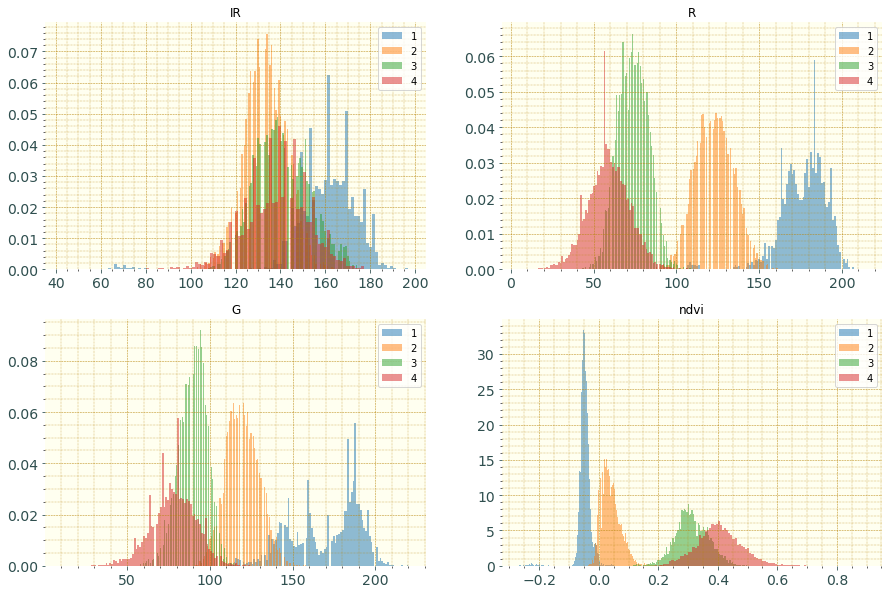

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
list_title = ['IR', 'R', 'G', 'ndvi']
my_iterator = zip(axes.flatten(), list_title)
for i, (ax, title) in enumerate(my_iterator):    
    for class_number, X in dict_X.items(): 
        if i ==3 :
            X = X.astype('int16') # Warning, you'll have unexpected results
                                  # if you keep data type as 'uint8'
                                  # try it if you're curious
            band = (X[:, 0] - X[:, 1]) / (X[:, 0] + X[:, 1])
        else:
            band = X[:, i]
        vals, bins, patch = ax.hist(band, bins=100,  density=True, label=class_number, alpha=0.5)
    ax.set_title(title)
    ax = plots.custom_bg(ax, x_grid=False, minor=False)
    ax.legend()
    

En utilisant seuleument les histogrammes interpolées :

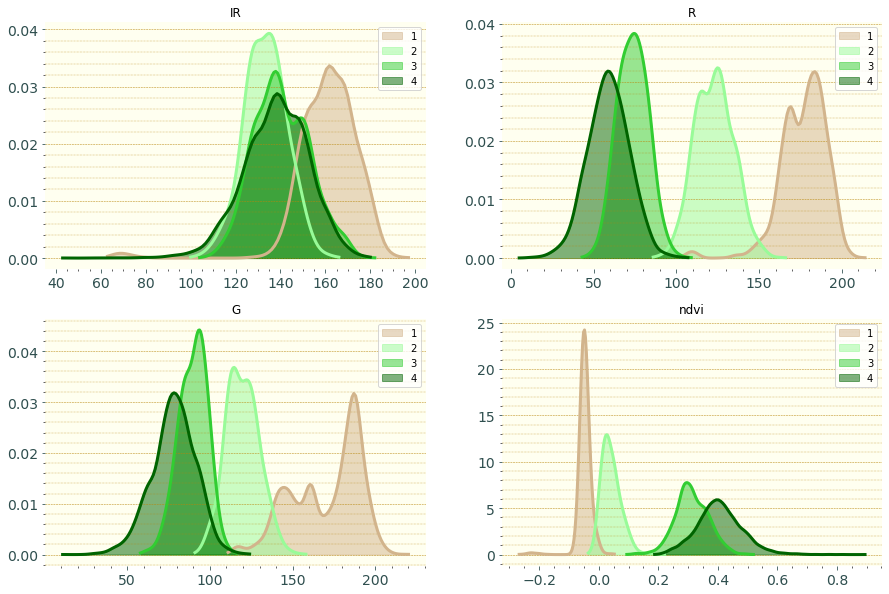

In [349]:
from sklearn.neighbors import KernelDensity
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
list_title = ['IR', 'R', 'G', 'ndvi']
my_iterator = zip(axes.flatten(), list_title)
color = ['tan', 'palegreen', 'limegreen', 'darkgreen']
for i, (ax, title) in enumerate(my_iterator):    
    for (class_number, X), col in zip(dict_X.items(), color): 
        if i ==3 :
            X = X.astype('int16')
            band = (X[:, 0] - X[:, 1]) / (X[:, 0] + X[:, 1])
            bandwidth = 0.01
        else: 
            band = X[:, i]
            bandwidth = 3
            
        # get 100 values between the min and the max of band
        X_plot = np.linspace(band.min(), band.max(), 100)[:, np.newaxis]

        # define kernel density
        kde = KernelDensity(bandwidth=bandwidth)
        # learn kernel
        kde.fit(band.reshape(-1, 1))
        # predict on our X
        log_dens = kde.score_samples(X_plot)
        density = np.exp(log_dens)

        # plot it
        ax.plot(X_plot[:,0], density ,zorder=3, linewidth=3,
                linestyle='-', color=col)
        ax.fill_between(X_plot[:,0], 0, density, alpha=0.5, color=col, label=class_number)
        ax.set_title(title)
        ax = plots.custom_bg(ax, x_grid=False)
    ax.set_title(title)
    ax = plots.custom_bg(ax, x_grid=False, minor=False)
    ax.legend()

#### Affichage interactif avec Plotly

==Plolty== est une librairie permettant de faire des graphiques interactifs qu'il est possible d'exporter au format html ou au format image. Vous trouverez [ici](https://plotly.com/python/) un lien explicitant son usage. 

Il est possible d'utiliser via deux interfaces :

- le module `plotly.express` qui permet de produire simplement des graphiques à partir de `DataFrame` de la librairie ==Pandas== (décidément, tout est lié !) ;
- le module `plotly.graph_objects` qui permet de produire des graphiques plus avancées mais une interface plus complexe.

Nous allons principalement utiliser le module `plotly.express` dans cette séance.

La première fonction que nous allons utiliser est la fonction `histogram`. La première étape consiste à convertir nos matrice `X` et `Y` en `DataFrame` :

In [548]:
# concatenate X and Y
data = np.concatenate((X, Y), axis=1)
# Conversion in data frame
df = pd.DataFrame(data, columns=['IR', 'R', 'G', 'id'])  
# Convert class label in str data type (necessary for the proper use 
# of the histogram function)
df['id'] = df['id'].astype(str)

In [549]:
import plotly.express as px
# define a correspondance dictionnary between class and color
color = {'1':'tan', '2':'palegreen', '3':'limegreen', '4':'darkgreen'}
fig = px.histogram(df, 
                   x="R",  # band to plot
                   color="id", # column containing the class label
                   color_discrete_map=color, # color dictionnary
                   opacity=0.5, 
                   barmode='overlay',
                   height = 700, width=800) # figure output size

# output parameters
out_folder = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/aumelas/'
out_figure = os.path.join(out_folder, '1D_histogram.html')

# export to html file
fig.write_html(out_figure)

Les avantages par rapport au figure de ==Matplotlib== sont que vous pouvez :
- obtenir des informations au passage de la sourie sur les données ;
- afficher ou non une classe.

### 2D scatter plot

Une autre possiblité pour explorer le comportement spectrale d'échantillons est d'afficher conjointement leur valeur sur deux bandes à l'aide d'un scatter plot à deux dimensions. 

In [360]:
import sys
sys.path.append('/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/python_scripts')
import os
from sklearn.model_selection import train_test_split

# personal librairies
import classification as cla

# 1 --- define parameters 
# inputs
my_folder = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/aumelas/'
sample_filename = os.path.join(my_folder, 'sample_strata.tif')
image_filename = os.path.join(my_folder, 'aumelas_orthoirc.tif')

# 2 --- extract samples 
dict_X, ditc_Y, dict_t = cla.get_samples_from_roi(image_filename, sample_filename, output_fmt='by_label')
X, Y, t = cla.get_samples_from_roi(image_filename, sample_filename)

Text(0.5, 0, 'R')

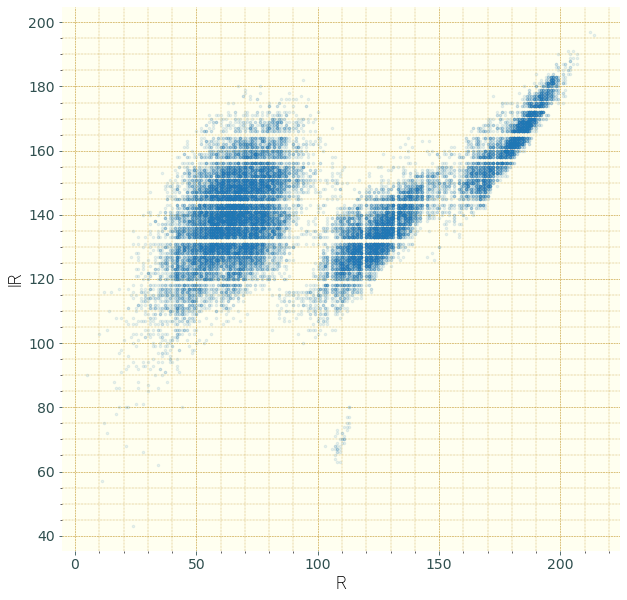

In [355]:
import plots
import matplotlib.pyplot as plt

# get desired bands
r = X[:, 1]
ir = X[:, 0]

# plot it 
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(r, ir, '.', alpha=0.1, ms=5)

# custom the graph
plots.custom_bg(ax)
ax.set_ylabel('IR')
ax.set_xlabel('R')

De la même manière que pour les histogrammes 1D, vous pouvez affichez des couleurs différentes pour chaque classe. Utilisons pour cela le dictionnaire `dict_X` :

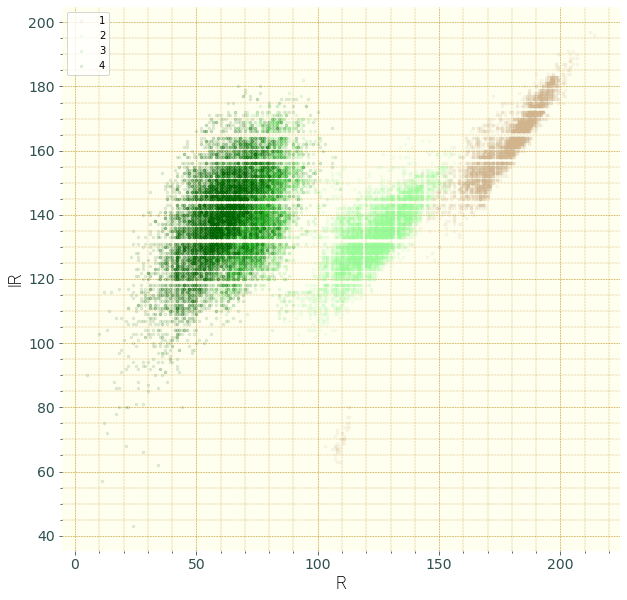

In [357]:
import plots
import matplotlib.pyplot as plt

# define colors
color = ['tan', 'palegreen', 'limegreen', 'darkgreen']

# define a new figure
fig, ax = plt.subplots(figsize=(10, 10))

# plot each class
for (class_number, X), col in zip(dict_X.items(), color): 

    r = X[:, 1]
    ir = X[:, 0]
    ax.plot(r, ir, '.', 
            alpha=0.1, # set transparency
            ms=5, # set point size
            color=col,
            label=class_number)

#custom grah
plots.custom_bg(ax)
ax.set_ylabel('IR')
ax.set_xlabel('R')
ax.legend()

Certaines classes ont des comportements spectraux similaire est il n'est pas facile de les distinguer. Vous pouvez jouer sur la paramètre de transparence `alpha` et la taille des point (`ms`) pour essayer d'améliorer le rendu. 

Essayez sinon d'utiliser la fonction `scatter` de ==poltly== : 

In [550]:
import pandas as pd
import plotly.express as px


# convert data into dataframe
data = np.concatenate((X, Y), axis=1)
df = pd.DataFrame(data, columns=['IR', 'R', 'G', 'id'])
df['id'] = df['id'].astype(str)

# define color dictionnary
color = {'1':'tan', '2':'palegreen', '3':'limegreen', '4':'darkgreen'}

# plot data
fig = px.scatter(df,
                 x="R", y="IR",  # desired bands
                 color="id",  ## column containing the class label
                 hover_data=['id'],
                 color_discrete_map=color,  #color dictionnary
                 opacity=0.5,  # point opacity 
                 height = 700, width =800)  # output figure size

# output parameters
out_folder = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/aumelas/'
out_figure = os.path.join(out_folder, '2D_scatter_plot.html')

#export graph
fig.write_html(out_figure)

Certaines classes sont toujours superposées mais vous pouvez afficher successivement les différentes classes pour une meilleure lisibilité. 

### 3D scatter plot

Nous allons cette fois afficher les valeurs spectrales des échantillons de trois bandes en même temps en utilisant la fonction `scatter_3D` de ==Plotly==.

In [551]:
import pandas as pd

color = {'1':'tan', '2':'palegreen', '3':'limegreen', '4':'darkgreen'}
data = np.concatenate((X, Y, ndvi, size), axis=1)
df = pd.DataFrame(data, columns=['IR', 'R', 'G', 'id', "ndvi", "size"])
df['id'] = df['id'].astype('int').astype(str)

In [552]:
import plotly.express as px
fig = px.scatter_3d(df, x="R", y="IR", z="G",
                    color="id",
                    hover_data=['id'],
                    color_discrete_map=color,
                    opacity=0.5,
                    height = 700, width =800)
out_folder = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/aumelas/'
out_figure = os.path.join(out_folder, '3D_scatter_plot.html')
fig.write_html(out_figure)

La taille des points vous parait certainement trop grande. Il n'est malheureusement pas possible de définir leur taille via la fonction `scatter_3d` du module `express` (voir [ici](https://plotly.com/python-api-reference/generated/plotly.express.scatter_3d.html) la documentation de la fonction. C'est une des limites de ce module. Pour changer, la taille des points, il faut mettre à jour *a posteriori* l'objet `fig` à l'aide de la méthode `update_traces`. 

In [553]:
import plotly.express as px
fig = px.scatter_3d(df, x="R", y="IR", z="G",
                    color="id",
                    hover_data=['id'],
                    color_discrete_map=color,
                    opacity=0.5,
                    height = 700, width =800)
fig.update_traces(marker=dict(size=2,
                              line=dict(width=0.2,
                                        color='DarkSlateGrey')
                             )
                 )
out_folder = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/aumelas/'
out_figure = os.path.join(out_folder, '3D_scatter_plot_V2.html')
fig.write_html(out_figure)


Remarques : 

Ce n'est pas le cas des fonction du module `express` mais pour le module `graph_objects` les paramètres d'entrée sont souvent à fournir sous forme de dictionnaire ce qui donne une syntaxe peu commune en python. C'est dû au fait que la librairie ==Plotly== est à l'origine une librairie Javascript où cette syntaxe est plus commune. 

Exercice

Reproduisez cet affichage 3D avec cette fois ci les bandes Rouge, Infra Rouge, et le NDVI : 

1. Construire un `DataFrame` contenant le NDVI ;
2. Afficher les bonnes bandes avec `scatter_3d`.

In [554]:
import pandas as pd

color = {'1':'tan', '2':'palegreen', '3':'limegreen', '4':'darkgreen'}
r = X[:, 1].astype('int16')
ir = X[:, 0].astype('int16')
ndvi = (ir - r)/(ir + r)
ndvi = np.atleast_2d(ndvi).T
data = np.concatenate((X, Y, ndvi, size), axis=1)
df = pd.DataFrame(data, columns=['IR', 'R', 'G', 'id', "ndvi", "size"])
df['id'] = df['id'].astype('int').astype(str)

In [556]:
import plotly.express as px
fig = px.scatter_3d(df, x="R", y="IR", z="ndvi",
                    color="id",
                    hover_data=['id'],
                    color_discrete_map=color,
                    opacity=0.5,
                    height = 650, width =650)
fig.update_traces(marker=dict(size=2,
                              line=dict(width=0.2,
                                        color='DarkSlateGrey')),
                  )
out_folder = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/aumelas/'
out_figure = os.path.join(out_folder, '3D_scatter_plot_V2_ndvi.html')
fig.write_html(out_figure)


Le NDVI apporte-t-il selon vous plus d'informations que les bandes Rouge et Infra-rouge ? 

<!-- selector=dict(mode='markers') -->

### Un peu de pratique

Exercice :

Essayez d'afficher un scatter plot 2D ou 3D (au choix), représentant les échantillons d'une seule classe, mais où les pixels de polygones différents ont une couleur différente (et donc où les pixels d'un même polygone ont la même couleur).

Solution

In [576]:
import sys
sys.path.append('/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/python_scripts')
import os
from sklearn.model_selection import train_test_split

# personal librairies
import classification as cla

# 1 --- define parameters 
# inputs
my_folder = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/aumelas/'
sample_filename = os.path.join(my_folder, 'sample_strata.tif')
image_filename = os.path.join(my_folder, 'aumelas_orthoirc.tif')
id_filename = os.path.join(my_folder, 'sample_strata_id.tif')

# 2 --- extract samples 
dict_X, ditc_Y, dict_t = cla.get_samples_from_roi(image_filename, sample_filename, output_fmt='by_label')
X, Y, t = cla.get_samples_from_roi(image_filename, sample_filename)
_, Y_id, t = cla.get_samples_from_roi(image_filename, id_filename)

In [580]:
import pandas as pd

color = {'1':'tan', '2':'palegreen', '3':'limegreen', '4':'darkgreen'}
r = X[:, 1].astype('int16')
ir = X[:, 0].astype('int16')
ndvi = (ir - r)/(ir + r)
ndvi = np.atleast_2d(ndvi).T
data = np.concatenate((X, ndvi, Y, Y_id), axis=1)
df = pd.DataFrame(data, columns=['IR', 'R', 'G', "ndvi", "class", "id"])
df['id'] = df['id'].astype('int').astype(str)
df['class'] = df['class'].astype('int').astype(str)

In [581]:
import plotly.express as px
fig = px.scatter_3d(df, x="R", y="IR", z="ndvi",
                    color="class", # here the columns containing the 
                                   # the class labels
                    hover_data=['id', "class"], # add the polygone id
                    color_discrete_map=color,
                    opacity=0.5,
                    height = 650, width =650)
fig.update_traces(marker=dict(size=2,
                              line=dict(width=0.2,
                                        color='DarkSlateGrey')),
                  )
out_folder = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/aumelas/'
out_figure = os.path.join(out_folder, '3D_scatter_plot_V3.html')
fig.write_html(out_figure)


In [ ]:
import plotly.express as px

df

fig = px.scatter_3d(df, x="R", y="IR", z="ndvi",
                    color="class",
                    hover_data=['id', "class"],
                    color_discrete_map=color,
                    opacity=0.5,
                    height = 650, width =650)
fig.update_traces(marker=dict(size=2,
                              line=dict(width=0.2,
                                        color='DarkSlateGrey')),
                  )
out_folder = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/aumelas/'
out_figure = os.path.join(out_folder, '3D_scatter_plot_V3.html')
fig.write_html(out_figure)

## Visualiser des images

Nous allons voir dans cette partie comment afficher des images avec ==Matplotlib==. Nous allons afficher l'image `imagette_fabas.tif` que vous avez téléchargée pendant le deuxième TD. 

### Affichage basique

La première étape consiste à charger l'image sous forme d'un tableau ==Numpy==. 

In [371]:
import sys
sys.path.append('/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/python_scripts')
import matplotlib.pyplot as plt
import read_and_write as rw

In [372]:
fabas_filename = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/imagette_fabas.tif'
img = rw.load_img_as_array(fabas_filename)

Il faut ensuite utiliser la fonction `imshow` : 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 444.5, 500.5, -0.5)

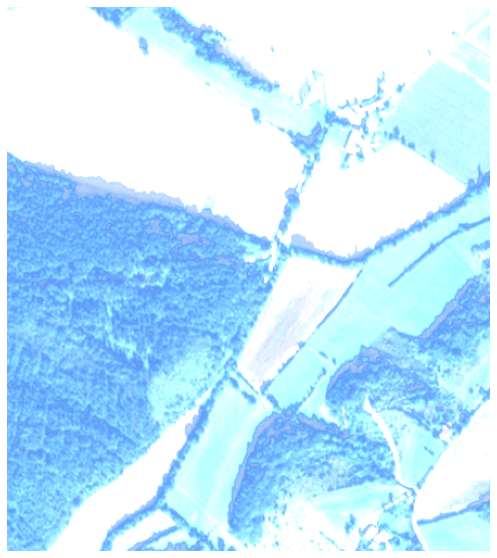

In [165]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)
ax.axis("off")  # delete borders

Regardons un extrait de la [documentation](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.imshow.html) de cette fonction : 

![](../../img/td_visu/extrait_doc.png)

Exercice :

Plusieurs formats de matrice-image en entrée sont possibles : lequel avons nous utilisé et est-ce le bon ? 

Exercice

Affichez l'image en composition infrarouge couleur. 

Solution

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 444.5, 500.5, -0.5)

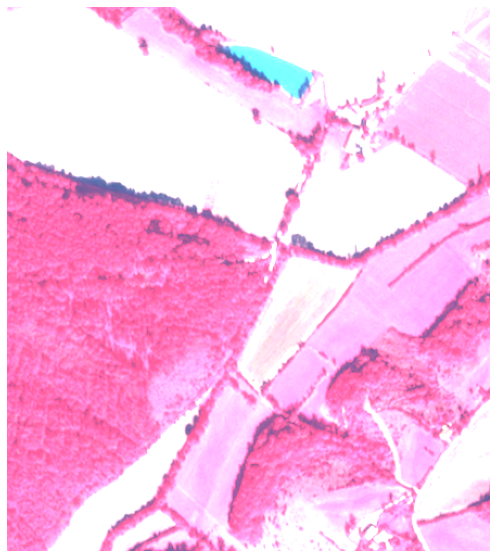

In [174]:
irc = img[:, :, :3].copy()
irc[:, :,0] = img[:, :,3]
irc[:, :,1] = img[:, :,0]
irc[:, :,2] = img[:, :,1]
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(irc)
ax.axis("off")

### améliorer le contraste de l'image

In [176]:
import sys
sys.path.append('/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/python_scripts')
import matplotlib.pyplot as plt
import read_and_write as rw

In [519]:
fabas_filename = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/imagette_fabas.tif'
img = rw.load_img_as_array(fabas_filename)

Nous allons maintenant voir comment améliorer le contraste d'une image. 

Par défaut  `imshow` considère pour les matrices d'entier que le maximum des données est de 255 et que le minimum est 0. Or notre image est codée en 'uint16' et le maximum des valeurs est supérieure à 255. Regardons l'histogramme de la bande IR pour s'en assurer : 


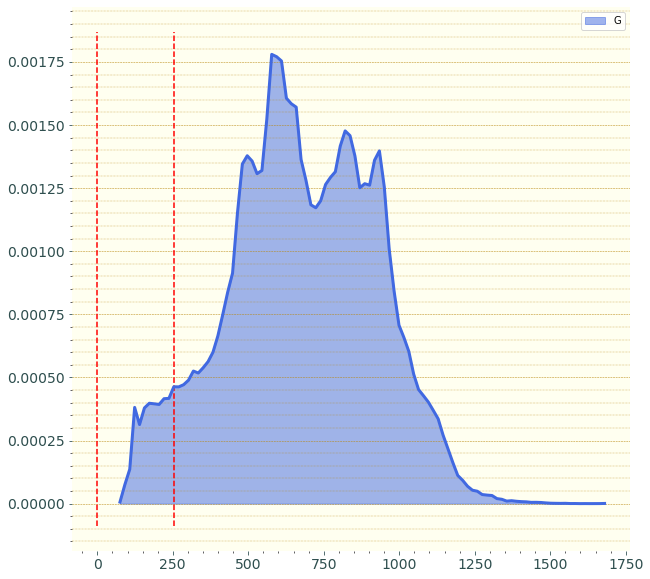

In [495]:
import matplotlib.pyplot as plt
import plots
from sklearn.neighbors import KernelDensity


fig, ax = plt.subplots(figsize=(10, 10))

band = img[:,:,3].flatten()
# get 100 values between the min and the max of band
X_plot = np.linspace(band.min(), band.max(), 100)[:, np.newaxis]

# define kernel density
kde = KernelDensity(bandwidth=5)
# learn kernel
kde.fit(band.reshape(-1, 1))
# predict on our X
log_dens = kde.score_samples(X_plot)
density = np.exp(log_dens)

# plot it
ax.plot(X_plot[:,0], density , color='royalblue', 
        zorder=3, linewidth=3,
        linestyle='-')
ax.fill_between(X_plot[:,0], 0, density, alpha=0.5, color='royalblue', label=label)
ax.legend()
ax = plots.custom_bg(ax, x_grid=False)
min, max = ax.get_ylim()
_ = ax.vlines([0, 255], min, max, color='red', ls='--')

Avec les paramètres actuels de la fonction `imshow` toutes les valeurs supérieures à 255 sont coupées et sont changées en 255 (d'où le message d'avertissement). C'est pour ça que l'image apparait trop contrastée dans l'exemple précédent. 

Pour remedier à ce problème, nous pouvons ré-échelonner les valeurs de notre image pour qu'elles soient comprise entre 0 et 255 en utilsant la formule ci-dessous : 

$$min_{dst} + \frac{max_{dst} - min_{dst}}{max_{src} - min_{src}} \times (img - min_{src})$$

Avec : 
- $min_{dst}$ et  $max_{dst}$, le minimum et le maximum de la nouvelle plage de valeur ;
- $min_{src}$ et $max_{src}$,  le minimum et le maximum de l'ancienne plage de valeur.

En Python on peut traduire la formule par :

In [520]:
min_src = img.min(axis=(0, 1))
max_src = img.max(axis=(0, 1))
min_dst = 0
max_dst = 255
img_rescale = min_dst + (max_dst - min_dst) / (max_src - min_src) * (img - min_src)

On peut vérifier que le maximum de chaque bande est maintenant bien de 255 :

In [521]:
print(img_rescale.max(axis=(0,1)))

[255. 255. 255. 255.]


L'histogramme de la bande Infra rouge est bien compris entre 0 et 255 :

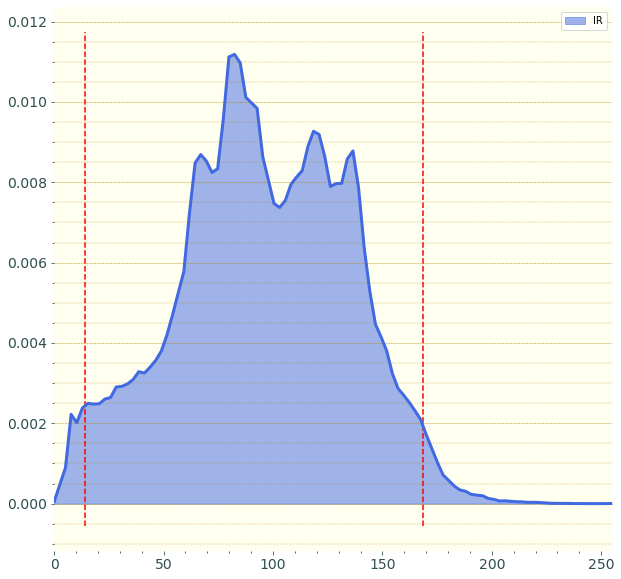

In [447]:
import matplotlib.pyplot as plt
import plots

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))

band = img_rescale[:,:,3].flatten()
# get 100 values between the min and the max of band
X_plot = np.linspace(band.min(), band.max(), 100)[:, np.newaxis]

# define kernel density
kde = KernelDensity(bandwidth=1)
# learn kernel
kde.fit(band.reshape(-1, 1))
# predict on our X
log_dens = kde.score_samples(X_plot)
density = np.exp(log_dens)

# plot it
ax.plot(X_plot[:,0], density , color='royalblue', 
        zorder=3, linewidth=3,
        linestyle='-')
ax.fill_between(X_plot[:,0], 0, density, alpha=0.5, color='royalblue', label='IR')
ax.set_xlim(0, 255)
ax.legend()
ax = plots.custom_bg(ax, x_grid=False)
 
p2 = np.percentile(band, 2)
p98 = np.percentile(band, 98)
min, max = ax.get_ylim()
_ = ax.vlines([p2 , p98] , min, max, color='red', ls='--')

Et le contraste de notre image s'est amélioré :

(-0.5, 444.5, 500.5, -0.5)

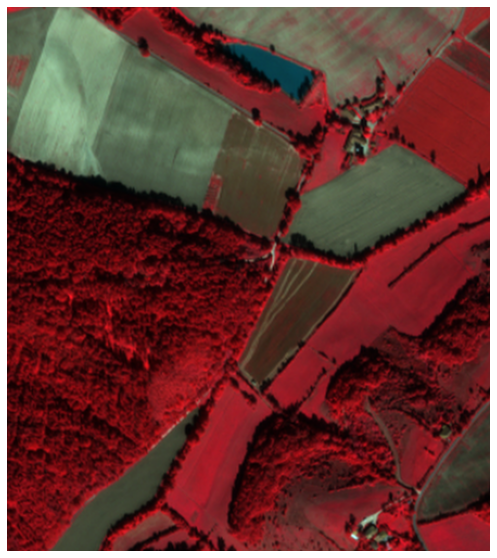

In [480]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
irc = img_rescale[:, :, :3].copy().astype('uint8')
irc[:, :,0] = img_rescale[:, :,3]
irc[:, :,1] = img_rescale[:, :,0]
irc[:, :,2] = img_rescale[:, :,1]
ax.imshow(irc)
ax.axis("off")

Nous venons de faire l'équivalent de l'opération sous QGIS:

![](../../img/td_visu/qgis_min_max.png)

Il est possible d'étirer l'histogramme des bandes du 2ième quantile au 98ième quantile. Au lieu de fixer `min_src = img.min(axis=(0,1))` on prendra `min_src = np.percentile(img, 2, axis=(0, 1))`. 

Il faudra cependant prendre garde à bien changer les valeurs inférieures et supérieures aux quantiles avant l'échellonnage : 

In [542]:
max_src = np.percentile(img, 98, axis=(0, 1))
min_src = np.percentile(img, 2, axis=(0, 1))
min_dst = 0
max_dst = 255

for idx_band, (p2, p98) in enumerate(zip(min_src, max_src)):
    
    img[(img[:,:, idx_band] < p2), idx_band] = p2
    img[(img[:,:, idx_band] > p98), idx_band] = p98

Puis échelonner : 

In [543]:
img_rescale = min_dst + (max_dst - min_dst) / (max_src - min_src) * (img - min_src)

On peut vérifier que les nouveaux maxima sont bien 255 : 

In [536]:
img_rescale.max(axis=(0,1))

array([255., 255., 255., 255.])

In [512]:
img = img_rescale.copy()

In [541]:
fabas_filename = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/imagette_fabas.tif'
img = rw.load_img_as_array(fabas_filename)

L'histogramme est plus étiré : 

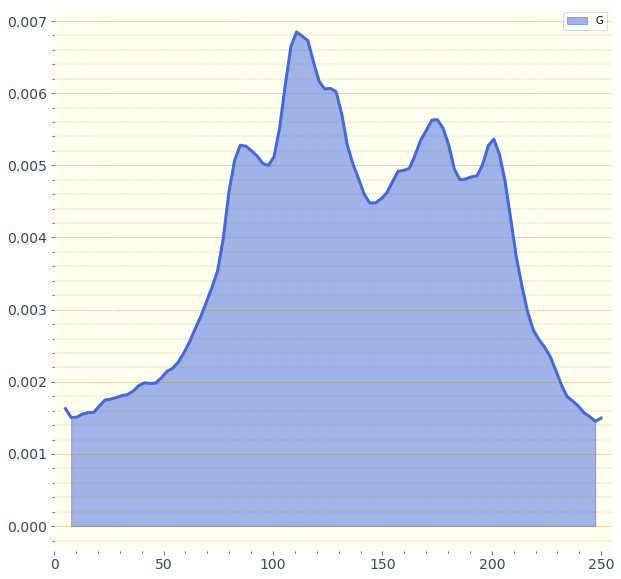

In [537]:
import matplotlib.pyplot as plt
import plots

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))

band = img_rescale[:,:,3].flatten()
# get 100 values between the min and the max of band
X_plot = np.linspace(band.min(), band.max(), 100)[:, np.newaxis]

# define kernel density
kde = KernelDensity(bandwidth=2)
# learn kernel
kde.fit(band.reshape(-1, 1))
# predict on our X
log_dens = kde.score_samples(X_plot)
density = np.exp(log_dens)

# plot it
ax.plot(X_plot[2:-2,0], density[2:-2] , color='royalblue', 
        zorder=3, linewidth=3,
        linestyle='-')
ax.fill_between(X_plot[3:-3,0], 0, density[3:-3], alpha=0.5, color='royalblue', label=label)
ax.legend()
ax.set_xlim(0, 255)
ax = plots.custom_bg(ax, x_grid=False)

Et le contraste de l'image encore amélioré :

(-0.5, 444.5, 500.5, -0.5)

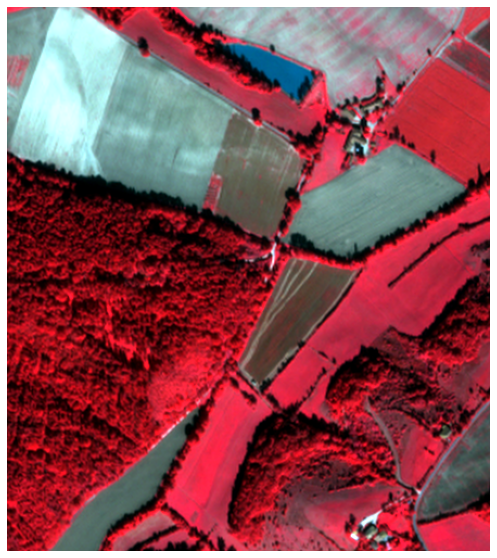

In [538]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
irc = img_rescale[:, :, :3].copy().astype('uint8')
irc[:, :,0] = img_rescale[:, :,3]
irc[:, :,1] = img_rescale[:, :,0]
irc[:, :,2] = img_rescale[:, :,1]
ax.imshow(irc)
ax.axis("off")

Nous venons de faire l'équivalent de l'opération sous QGIS:

![](../../img/td_visu/qgis_percentile.png)